## Data Acquisition

In [128]:
from os import listdir
from os.path import isfile, join

import pandas as pd

In [129]:
def merge_dataset(data_files: str = "../datasets", symbol: str = "btc"):
    files = [f for f in listdir(data_files) if isfile(join(data_files, f)) and f.startswith(symbol) and f.endswith('.parquet')]
    return pd.concat(
        pd.read_parquet(join(data_files, f), engine='fastparquet') for f in files
    )

In [130]:
def prepare_dataset(data_files: str = "../datasets", symbol: str = "btc", datetime_index: bool = True):
    df = merge_dataset(data_files=data_files, symbol=symbol)
    
    # timestamp to python datetime
    if datetime_index:
        df['date'] = pd.to_datetime(df['date'], unit='s')

    df = df.set_index(['date'])
    df.sort_index(inplace=True)

    return df

In [131]:
btc_trades_df = prepare_dataset()

In [132]:
btc_trades_df.head()

,type,price,amount
date,,,
2013-06-12 08:39:21,buy,249.0,0.381000
2013-06-12 10:34:30,buy,249.0,0.020000
2013-06-12 16:16:07,buy,249.0,3.564896
2013-06-12 16:16:07,buy,249.0,1.387382
2013-06-12 16:43:47,buy,260.0,0.130480


In [133]:
btc_trades_df.tail()

,type,price,amount
date,,,
2024-03-24 22:47:10,buy,336286.893944,0.000006
2024-03-24 22:47:18,buy,336347.116719,0.000004
2024-03-24 22:47:32,sell,336062.300849,0.000816
2024-03-24 22:47:42,sell,336062.300899,0.000191
2024-03-24 22:47:52,sell,335797.000000,0.000006


In [134]:
btc_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16529676 entries, 2013-06-12 08:39:21 to 2024-03-24 22:47:52
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   type    object 
 1   price   float64
 2   amount  float64
dtypes: float64(2), object(1)
memory usage: 504.4+ MB


In [135]:
btc_trades_df.describe()

,price,amount
count,1.652968e+07,1.652968e+07
mean,1.421893e+05,3.605958e-02
std,1.111363e+05,1.918438e-01
min,0.000000e+00,0.000000e+00
25%,3.781700e+04,7.283800e-04
50%,1.209170e+05,3.506680e-03
75%,2.319979e+05,1.746010e-02
max,3.800000e+05,6.600000e+01


## Exploratory Data Analysis

In [6]:
# TBD

## Models

### Isolation Forest

In [158]:
import numpy as np
from sklearn.ensemble import IsolationForest

In [171]:
model = IsolationForest(
    n_estimators=1_000,
    max_samples='auto',
    contamination='auto',
    random_state=139,
    n_jobs=-1
)

In [172]:
df = btc_trades_df.loc['2023-09-29':'2023-09-29'][['price', 'amount']]

In [173]:
df

,price,amount
date,,
2023-09-29 00:01:02,136361.000000,0.000722
2023-09-29 00:03:58,136150.820050,0.000738
2023-09-29 00:04:44,136345.670000,0.003645
2023-09-29 00:06:03,136345.670000,0.002445
2023-09-29 00:06:16,136106.140000,0.000024
...,...,...
2023-09-29 23:53:43,135573.140000,0.000221
2023-09-29 23:55:02,135479.486492,0.000023
2023-09-29 23:57:12,135479.486492,0.000015


In [174]:
model.fit(df[['price']])

IsolationForest(n_estimators=1000, n_jobs=-1, random_state=139)

In [175]:
model.offset_

-0.5

In [177]:
df['scores'] = model.decision_function(df[['price']])
df['anomaly'] = model.predict(df[['price']])

In [186]:
scores = model.score_samples(df[['price']])
scores

array([-0.59317966, -0.53579575, -0.58692915, ..., -0.45706755,
       -0.45693224, -0.45693224])

In [180]:
np.mean(scores)

-0.48184760870629256

In [181]:
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)

#### Anomaly Scores

Text(0.5, 1.0, 'Anomaly Scores returned by Isolation Forest')

<Figure size 1200x800 with 0 Axes>

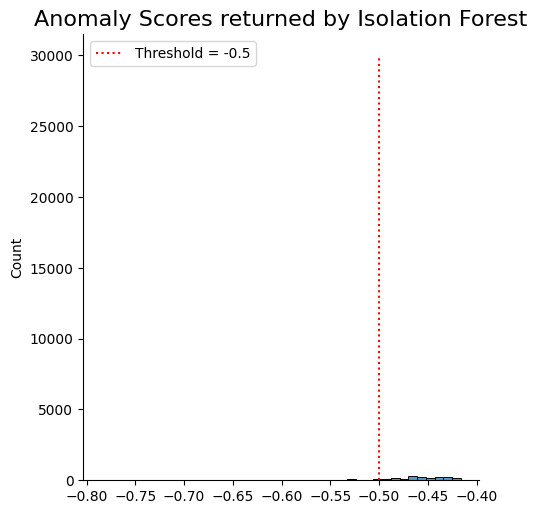

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.displot(scores, kde=False)
line = plt.vlines(model.offset_, 0, 30000, colors='r', linestyles='dotted')
line.set_label(f'Threshold = {model.offset_}')
plt.legend(loc='upper left', fontsize='medium')
plt.title('Anomaly Scores returned by Isolation Forest', fontsize=16)

### One-Class SVM

In [ ]:
# WIP